In [ ]:
%reset -f
import plotly.express as px
from graphviz import Digraph
from collections import defaultdict
from itertools import product
import numpy as np

In [ ]:
LAM = 1.0
b = 2
P = [0.6, 0.4]
QUEUE_SIZES = [2]
ERLANG_IDX = 1
ERLANG_N = 3

# egormit.
#QUEUE_SIZES = [2, 0]; ERLANG_IDX = 0; ERLANG_N = 2; LAM = 0.6; b = 10; P = [0.5, 0.5]

# Print
N = 2 # number of devices
MU = 1/b
assert sum(P) == 1
print(f"λ = {LAM}\n{b = }\nμ = {MU}")
for i in range(len(P)):
    print(f'p{i+1} = {P[i]}')


λ = 1.0
b = 2
μ = 0.5
p1 = 0.6
p2 = 0.4


In [ ]:
# State: (N device states, N queue states)

# Add device states
ranges = [range(2)] * N
ranges[ERLANG_IDX] = range(ERLANG_N + 1)

# Add queue states
ranges += [range(q + 1) for q in QUEUE_SIZES]

def state_possible(state):
    for i in range(N):
        if state[i] == 0 and state[N] != 0:
            return False
    for s in state:
        assert s >= 0
    return True

states = {
    state: {}
    for state in product(*ranges)
    if state_possible(state)
}

print(f'{len(states) = }')

for in_state in states:
    for idx in range(N):
        out_state_serve = [v for v in in_state]
        out_state_arrive = [v for v in in_state]
        out_state_erlang_proc = [v for v in in_state]

        if idx == ERLANG_IDX:
            # Erlang case
            if out_state_erlang_proc[idx] == ERLANG_N:
                # Completion: go idle or take from queue
                if out_state_erlang_proc[N] == 0:
                    out_state_erlang_proc[idx] = 0
                else:
                    out_state_erlang_proc[idx] = 1
                    out_state_erlang_proc[N] -=1
            elif out_state_erlang_proc[idx] > 0:
                # Progress
                out_state_erlang_proc[idx] += 1
        else:
            # Maybe something got served on a non-erlang device... Is device active?
            if out_state_serve[idx] > 0:
                assert idx == ERLANG_IDX or out_state_serve[idx] == 1 # non-erlang case, only 1 active state in device
                # Remove from queue or device
                if out_state_serve[N] > 0:
                    out_state_serve[N] -= 1
                else:
                    out_state_serve[idx] = 0

        # Maybe something arrived... Do we have space in queue (if any) or device?
        if (out_state_arrive[N] < QUEUE_SIZES[0]) or out_state_arrive[idx] == 0:
            # Insert into device or queue
            if out_state_arrive[idx] == 0:
                assert out_state_arrive[N] == 0 # if device is empty, queue must also be
                out_state_arrive[idx] = 1
            else:
                out_state_arrive[N] += 1

        out_state_serve = tuple(out_state_serve)
        out_state_arrive = tuple(out_state_arrive)
        out_state_erlang_proc = tuple(out_state_erlang_proc)
        # assert out_state_arrive in states
        assert out_state_serve in states
        assert out_state_erlang_proc in states

        if out_state_serve != in_state:
            states[in_state][out_state_serve] = (MU, 'green')
        if out_state_arrive != in_state and state_possible(out_state_arrive):
            states[in_state][out_state_arrive] = (P[idx] * LAM, 'red')
        if out_state_erlang_proc != in_state:
            states[in_state][out_state_erlang_proc] = (ERLANG_N * MU, 'blue')

len(states) = 14


In [ ]:
for state, transition in states.items():
    for in_state in states.keys():
        print(f"State: {in_state}")
    for in_state, out_states in states.items():
        for out_state, (rate, color) in out_states.items():
             print(f"  -> Next State: {out_state} with Probability: {rate:.4f}")

State: (0, 0, 0)
State: (0, 1, 0)
State: (0, 2, 0)
State: (0, 3, 0)
State: (1, 0, 0)
State: (1, 1, 0)
State: (1, 1, 1)
State: (1, 1, 2)
State: (1, 2, 0)
State: (1, 2, 1)
State: (1, 2, 2)
State: (1, 3, 0)
State: (1, 3, 1)
State: (1, 3, 2)
  -> Next State: (1, 0, 0) with Probability: 0.6000
  -> Next State: (0, 1, 0) with Probability: 0.4000
  -> Next State: (1, 1, 0) with Probability: 0.6000
  -> Next State: (0, 2, 0) with Probability: 1.5000
  -> Next State: (1, 2, 0) with Probability: 0.6000
  -> Next State: (0, 3, 0) with Probability: 1.5000
  -> Next State: (1, 3, 0) with Probability: 0.6000
  -> Next State: (0, 0, 0) with Probability: 1.5000
  -> Next State: (0, 0, 0) with Probability: 0.5000
  -> Next State: (1, 1, 0) with Probability: 0.4000
  -> Next State: (0, 1, 0) with Probability: 0.5000
  -> Next State: (1, 1, 1) with Probability: 0.4000
  -> Next State: (1, 2, 0) with Probability: 1.5000
  -> Next State: (1, 1, 0) with Probability: 0.5000
  -> Next State: (1, 1, 2) with Pr

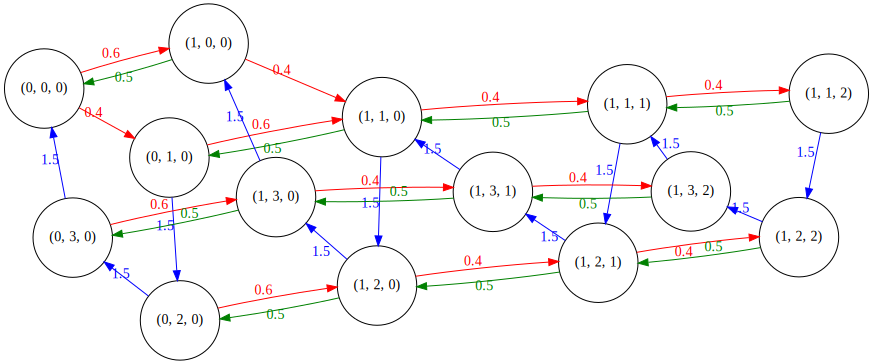

In [ ]:
def make_state_graph(states):
    g = Digraph(engine='sfdp')
    g.attr(overlap='scalexy')
    for in_state in states.keys():
        id = str(in_state)
        g.node(id, id, shape='circle')
    for in_state, out_states in states.items():
        for out_state, (rate, color) in out_states.items():
            in_id = str(in_state)
            out_id = str(out_state)
            g.edge(in_id, out_id, f'{rate:.3}', color=color, fontcolor=color)
    return g

display(make_state_graph(states))

In [ ]:
def make_state_indices(states):
    idx = {}
    for i, state in enumerate(states):
        idx[state] = i
        idx[i] = state
    return idx

def make_transition_rate_matrix(states, state_idx):
    N = len(states)
    m = np.zeros((N, N))
    for in_state, out_states in states.items():
        in_idx = state_idx[in_state]
        for out_state, (rate, _color) in out_states.items():
            out_idx = state_idx[out_state]
            m[in_idx, out_idx] = rate
    for i in range(N):
        m[i, i] = -sum(m[i, :])
    return m

state_idx = make_state_indices(states)
transition_rate_matrix = make_transition_rate_matrix(states, state_idx)

fig = px.imshow(
    transition_rate_matrix,
    text_auto = True,
    height = 800,
    color_continuous_scale = [[0, 'red'], [0.5, '#f8f8f8'], [1, 'green']],
    color_continuous_midpoint = 0.0,
)
fig.update_layout(
    title='Filtered Transition Rate Matrix',
    xaxis_title='Next State',
    yaxis_title='Current State',
)
fig.show()

In [ ]:
def solve_states(transition_rate_matrix):
    shape = transition_rate_matrix.shape
    assert len(shape) == 2
    assert shape[0] == shape[1]
    N = shape[0]

    equations = transition_rate_matrix.copy().transpose()
    equations[0, :] = np.ones(N)
    bvector = np.zeros(N)
    bvector[0] = 1
    return np.linalg.solve(equations, bvector)

probs = solve_states(transition_rate_matrix)

for i in range(len(states)):
    print(f'{i}\t{state_idx[i]}\t{probs[i]:.4}')

0	(0, 0, 0)	0.2202
1	(0, 1, 0)	0.06185
2	(0, 2, 0)	0.06172
3	(0, 3, 0)	0.06022
4	(1, 0, 0)	0.2598
5	(1, 1, 0)	0.08361
6	(1, 1, 1)	0.02323
7	(1, 1, 2)	0.004646
8	(1, 2, 0)	0.07367
9	(1, 2, 1)	0.02872
10	(1, 2, 2)	0.009229
11	(1, 3, 0)	0.06777
12	(1, 3, 1)	0.03202
13	(1, 3, 2)	0.01333


In [ ]:
y =  np.array(P) * (LAM / MU) # Нагрузка
pbusy = np.zeros(len(P)) # Загрузка
L = np.zeros(len(P)) # Длина очереди
m = np.zeros(len(P)) # Число заявок
prod = np.zeros(len(P)) # Производительность
loss = np.zeros(len(P)) # Вероятность потери
wtime = np.zeros(len(P)) # Время ожидания
ttime = np.zeros(len(P)) # Время пребывания

for si, prob in enumerate(probs):
  state = state_idx[si]
  for did in range(N):
    if state[did] != 0:
      pbusy[did] += prob
    L[did] += prob * state[N]
    if state[did] > 0:
      m[did] += prob * (1 + state[N])
    if state[N] == QUEUE_SIZES[0] and state[did] > 0:
      loss[did] += prob
prod = LAM * np.array(P) * (1 - loss)
wtime = L / prod
ttime = m / prod

print(f'Нагрузка      {y = } Σ {sum(y)}')
print(f'Загрузка      {pbusy = } Σ {sum(pbusy)}')
print(f'Длина очереди {L}, Σ {sum(L)}')
print(f'Число заявок  {m}, Σ {sum(m)}')
print(f'Время ожидания       {wtime}, Σ {sum(L) / sum(prod)}')
print(f'Время пребывания     {ttime}, Σ {sum(m) / sum(prod)}')
print(f'Вероятность потери   {loss}, Σ {sum(loss * P)}')
print(f'Производительность   {prod}, Σ {sum(prod)}')

Нагрузка      y = array([1.2, 0.8]) Σ 2.0
Загрузка      pbusy = array([0.5959894 , 0.52002491]) Σ 1.116014313894009
Длина очереди [0.13837825 0.13837825], Σ 0.27675650687179193
Число заявок  [0.73436766 0.65840316], Σ 1.3927708207658007
Время ожидания       [0.23707935 0.35561903], Σ 0.2844952231121829
Время пребывания     [1.2581703  1.69203389], Σ 1.4317157340819526
Вероятность потери   [0.02720157 0.02720157], Σ 0.02720156829255229
Производительность   [0.58367906 0.38911937], Σ 0.9727984317074477


In [ ]:
import pandas as pd
df = {
  'name': [
    'Нагрузка',
    'Загрузка',
    'Длина очереди',
    'Число заявок',
    'Время ожидания',
    'Время пребывания',
    'Вероятность потери',
    'Производительность',
  ],
  'sys1': [
    2,
    1.809,
    2.696,
    4.505,
    3.419,
    5.7132,
    0.211,
    0.789,
  ],
  'sys2': [
    2,
    1.116,
    0.277,
    1.3927,
    0.2844,
    1.4317,
    0.0272,
    0.9727,
  ],
}
df = pd.DataFrame(df)

df_melted = df.melt(id_vars='name', var_name='system', value_name='value')

fig = px.histogram(
    df_melted,
    x='name',
    y='value',
    color='system',
    barmode='group',  # Use 'group' mode to place bars side by side
    title='Comparison of Metrics Between System 1 and System 2',
)

# Show the figure
fig.show()